<a href="https://colab.research.google.com/github/blackcaer/SMF-training/blob/main/SMF_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Initializing
from google.colab import drive
drive.mount('/content/drive/')

!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd  # https://github.com/microsoft/LightGBM/issues/5914

!pip install lightgbm --config-settings=cmake.define.USE_GPU=ON

!pip install scikit-optimize

import lightgbm as lgb
from IPython.display import display

import os
import json
#import time
import gc
import random
import psutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import traceback

from datetime import datetime
from functools import partial

from google.colab import files
from sys import getsizeof
from time import time
import pprint
import joblib

from collections import defaultdict, Counter
from itertools import combinations

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

from scipy.fftpack import fft
from scipy.stats import zscore

!pip install optuna
!pip install optuna-integration[lightgbm]
import optuna
from optuna.integration import LightGBMPruningCallback

from torch.cuda import get_device_name,is_available
#from os import cpu_count

#print(f"Liczba rdzeni procesora: {cpu_count()} (realnych 2x mniej prawdopodobnie)")
gpu_available = is_available()

if gpu_available:
    print("GPU avalibe.")
    print("Name of GPU:", get_device_name(0))
else:
    print("GPU is not avalibe.")
_features_added=False


Mounted at /content/drive/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


GPU is not avalibe.


In [2]:
#@title Constants

ITEMS_PHSM_JSON = '/content/drive/My Drive/SMF_files/items_phsm.json'
ITEMS_PHSM_JSON_TEST = '/content/drive/My Drive/SMF_files/items_phsm_test.json'

PLAYER_COUNT_JSON = '/content/drive/My Drive/SMF_files/rust_player_count_interpolated.json'

SPIKES_TH=2
SPIKES_TH_TEST=1.5
SPIKES_PATH='/content/drive/My Drive/SMF_files/spikes_correction.csv'
SPIKES_PATH_TEST='/content/drive/My Drive/SMF_files/spikes_correction_test.csv'

MODEL_SAVES_PATH='/content/drive/MyDrive/SMF_files/model_saves'
OPT_SAVES_PATH="/content/drive/MyDrive/SMF_files/opt_saves/"

ITEMS_TO_EXCLUDE=['Metal Tree Door'] # 'Metal Tree Door' - one of the rarest items in the game, very few sales since 2018

In [3]:
#@title Params
TEST_MODE = 1
MAKE_SPIKES_CORR_FILE=0


In [42]:
#@title Helpers
def get_learning_summary(y_pred_train, y_train, y_pred_test, y_test, y_pred_naive, label="[no label]"):
  """ Returns dataframe with metrics"""

  #print('=' * 8 + " " + label + " " + '=' * 8)
  #rmse_naive = mean_squared_error(y_test, y_pred_naive, squared=False)
  #rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
  #print(f'RMSE change: {(1 - rmse_test / rmse_naive) * -100:.2f}%   (naive->test)')

  results = {
      "Metric": ["Accuracy", "RMSE", "MAE", "MAPE", "Max Error", "Median Absolute Error"],
      "Train": calc_accuracy(y_pred_train, y_train, "Train accuracy:"),
      "Valid": calc_accuracy(y_pred_test, y_test, "Validation accuracy:"),
      "Naive": calc_accuracy(y_pred_naive, y_test, "Naive accuracy:")
  }

  #display(df)
  return pd.DataFrame(results)

def calc_accuracy(pred, actual, label=""):
  """ Returns accuracy metrics: accuracy, rmse, mae, mape, max_error, median_absolute_error """
  N=3
  errors = np.abs(pred - actual)
  accuracy = round(100 * (1 - np.mean(errors / actual)), N)
  max_error = round(np.max(errors), N)
  std_deviation = round(np.std(errors), N)
  mae = round(np.mean(errors), N)
  median_absolute_error = round(np.median(errors), N)
  mape = round(mean_absolute_percentage_error(actual, pred), N)
  rmse = round(root_mean_squared_error(actual, pred), N)

  return accuracy, rmse, mae, mape, max_error, median_absolute_error

def print_importances(model,start=0,print_tab=False,name="",figsize=(10, 18),end=-1):
  importance = model.feature_importance(importance_type='gain')  # 'split' lub 'gain'
  feature_names = model.feature_name()

  trim=0
  importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
  importance_df = importance_df.sort_values(by='Importance', ascending=False)[start:end]

  # Wizualizacja
  print(f"Trimmed first {trim} features to see better")
  plt.figure(figsize=figsize)
  plt.barh(importance_df['Feature'], importance_df['Importance'])
  plt.xlabel('Importance')
  plt.title(f'Feature Importance {name}')
  plt.style.use('dark_background')
  plt.gca().invert_yaxis()
  plt.show()
  pd.set_option('display.max_rows', None)
  if print_tab:
    display(importance_df)

def aggregate_pricehistories(pricehistories):
    interpolated_histories = []
    max_date = max(df.index.max() for df in pricehistories)
    for df in pricehistories:
        df_resampled = df.resample('D').interpolate(method='linear')
        full_date_range = pd.date_range(start=df_resampled.index.min(), end=max_date, freq='D')
        df_reindexed = df_resampled.reindex(full_date_range)
        df_filled = df_reindexed.ffill()

        interpolated_histories.append(df_filled)

    all_data = pd.concat(interpolated_histories)

    sum = all_data.groupby(all_data.index).sum()
    med = all_data.groupby(all_data.index).median()
    mean = all_data.groupby(all_data.index).mean()

    plot_pricehistory([med[:],mean[:]],['med','mean'],"Test")
    plot_pricehistory([sum[:]],['sum'],"Test",1)
    return sum,med,mean

def col_from_idx(df,idx_name,pos=None):
  df[idx_name] = df.index.get_level_values(idx_name)
  if pos is not None:
    cols = df.columns.tolist()
    cols.insert(pos, cols.pop(cols.index(idx_name)))
    df = df[cols]

def rmse_top_items_analysis(y_actual,y_pred,data_mapped,show_top_items=False):
  squared_errors = np.power(np.abs(y_actual - y_pred),2)

  data_mapped_with_errors = data_mapped.assign(squared_error=squared_errors.values)
  avg_rmse_per_item = np.sqrt(data_mapped_with_errors.groupby('name')['squared_error'].mean())

  top_item_rmse = avg_rmse_per_item.nlargest(10)
  if show_top_items:
    print("Top items with largest rmse:")
    print(top_item_rmse)

  items_to_exclude = top_item_rmse.index
  mask = ~data_mapped.index.get_level_values('name').isin(items_to_exclude)

  filtered_data_mapped = data_mapped[mask]
  filtered_y_actual = y_actual[mask]
  filtered_y_pred = y_pred[mask]
  rmse_without_top_items = mean_squared_error(filtered_y_actual, filtered_y_pred,squared=False)
  rmse_normal = mean_squared_error(y_actual, y_pred, squared=False)
  print(f'\nRMSE without top items: {rmse_without_top_items:.4f} (Change {(rmse_without_top_items/rmse_normal-1)*100:.2f}%)\n')
  return top_item_rmse

def plot_pricehistory(pricehistories:list,labels:list,title,day_interval=60,relative_x_axis=False,figsize=(16, 6)):
  plt.style.use('dark_background')
  plt.figure(figsize=figsize)
  ax = plt.gca()
  for i in range(len(pricehistories)):
    if relative_x_axis:
      days_from_start = (pricehistories[i].index - pricehistories[i].index[0]).days

      plt.plot(days_from_start, pricehistories[i].values, label=labels[i])
      ax.set_xticks(days_from_start[::day_interval])
      ax.set_xticklabels(days_from_start[::day_interval])
    else:
      plt.plot(pricehistories[i], label=labels[i])
      #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
      ax.xaxis.set_major_locator(mdates.DayLocator(interval=day_interval))
      ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

  ax.grid(True)
  ax.grid(color='gray', linestyle='--', linewidth=0.5)
  plt.xticks(rotation=45)
  plt.xlabel('Date' if not relative_x_axis else 'Days from Start')
  plt.ylabel('Price')
  plt.title(title)
  plt.legend()
  plt.show()

def plot_predictions_vs_actuals(test_dataset, predictions, item_name,label_main="",label1='real',label2='pred'):
  item_data = test_dataset.xs(item_name, level='name',drop_level=False)

  if len(item_data)==0:
    print(f"{item_name} is not in given data")
    return

  item_actuals = item_data['price']
  item_predictions = predictions[item_data.index]

  plot_df = pd.DataFrame({'date': item_data.index.get_level_values('date'), 'actual': item_actuals, 'predicted': item_predictions})

  rmse = mean_squared_error(item_actuals, item_predictions, squared=False)

  print(f'RMSE {item_name}: {rmse}')

  plt.style.use('dark_background')
  plt.figure(figsize=(12, 6))
  plt.plot(plot_df['date'], plot_df['actual'], label=label1)
  plt.plot(plot_df['date'], plot_df['predicted'], label=label2)

  plt.xticks(rotation=45)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title(f'{item_name}: {label_main} {label1} vs {label2}')
  plt.legend()
  plt.show()


"""reducing.py
Author: Kirgsn, 2018
"""
from joblib import Parallel, delayed
from fastprogress import master_bar, progress_bar

def measure_time_mem(func):
    def wrapped_reduce(self, df, *args, **kwargs):
        # pre
        mem_usage_orig = df.memory_usage().sum() / self.memory_scale_factor
        start_time = time()
        # exec
        ret = func(self, df, *args, **kwargs)
        # post
        mem_usage_new = ret.memory_usage().sum() / self.memory_scale_factor
        end_time = time()
        print(f'reduced df from {mem_usage_orig:.4f} MB '
              f'to {mem_usage_new:.4f} MB '
              f'in {(end_time - start_time):.2f} seconds')
        gc.collect()
        return ret
    return wrapped_reduce


class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe into, in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None, use_categoricals=True, n_jobs=-1):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        :param use_categoricals: Whether the new pandas dtype "Categoricals"
                shall be used
        :param n_jobs: Parallelization rate
        """

        self.conversion_table = \
            conv_table or {'int': [np.int8, np.int16, np.int32, np.int64],
                           'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                           'float': [np.float32, ]}
        self.null_int = {   np.int8:  pd.Int8Dtype,
                            np.int16: pd.Int16Dtype,
                            np.int32: pd.Int32Dtype,
                            np.int64: pd.Int64Dtype,
                            np.uint8: pd.UInt8Dtype,
                            np.uint16:pd.UInt16Dtype,
                            np.uint32:pd.UInt32Dtype,
                            np.uint64:pd.UInt64Dtype}

        self.use_categoricals = use_categoricals
        self.n_jobs = n_jobs

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    @measure_time_mem
    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=self.n_jobs, max_nbytes=None)(progress_bar(list(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)))
        del df
        gc.collect()
        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):
        try:
            isnull = False
            # skip NaNs
            if s.isnull().any():
                isnull = True
            # detect kind of type
            coltype = s.dtype
            if np.issubdtype(coltype, np.integer):
                conv_key = 'int' if s.min() < 0 else 'uint'
            elif np.issubdtype(coltype, np.floating):
                conv_key = 'float'
                asint = s.fillna(0).astype(np.int64)
                result = (s - asint)
                result = np.abs(result.sum())
                if result < 0.01:
                    conv_key = 'int' if s.min() < 0 else 'uint'
            else:
                if isinstance(coltype, object) and self.use_categoricals:
                    # check for all-strings series
                    if s.apply(lambda x: isinstance(x, str)).all():
                        if verbose: print(f'convert {colname} to categorical')
                        return s.astype('category')
                if verbose: print(f'{colname} is {coltype} - Skip..')
                return s
            # find right candidate
            for cand, cand_info in self._type_candidates(conv_key):
                if s.max() <= cand_info.max and s.min() >= cand_info.min:
                    if verbose: print(f'convert {colname} to {cand}')
                    if isnull:
                        return s.astype(self.null_int[cand]())
                    else:
                        return s.astype(cand)

            # reaching this code is bad. Probably there are inf, or other high numbs
            print(f"WARNING: {colname} doesn't fit the grid with \nmax: {s.max()} "
                f"and \nmin: {s.min()}")
            print('Dropping it..')
        except Exception as ex:
            print(f'Exception for {colname}: {ex}')
            return s

def reduce_mem_usage(df):
  return Reducer().reduce(df)

In [5]:
#@title DataPrepper
class DataPrepper:
    def __init__(self):
        self.val_df = None
        self.train_df = None
        self.items_phsm_df = None
        self.rust_player_count_df = None
        self.dataset: pd.DataFrame = None
        self.columns_to_drop = [
            'previewUrl', 'views', 'timeCreated', 'timeRefreshed', 'isAvailableOnStore', 'creatorName',
            'appId',
            'id', 'nameId','hasGlow', 'hasCutout','timeAccepted'] # 'hasGlow', 'hasCutout' - no gain, no splits
        self.desired_column_order = ['date', 'price', 'volume', 'name', 'playerCount', 'supplyTotalEstimated',
                                     'storePrice',
                                     'glowRatio',  'cutoutRatio', 'hasGlowSights', 'facepunchSkin',
                                     'itemType',
                                     'itemCollection',
                                     ]

    def load_data(self):
        """
        Loads self.items_phsm_df and self.rust_player_count_df from files.
        """
        with open(ITEMS_PHSM_JSON if not TEST_MODE else ITEMS_PHSM_JSON_TEST, 'r') as f:
            items_phsm = json.load(f)

        with open(PLAYER_COUNT_JSON, 'r') as f:
            rust_player_count_json = json.load(f)

        items_phsm = [item for item in items_phsm if item['name'] not in ITEMS_TO_EXCLUDE]

        phsm_records = self.unfold_phsm(items_phsm)

        self.items_phsm_df = pd.DataFrame(phsm_records)

        self.rust_player_count_df = pd.DataFrame(rust_player_count_json)

        print("Loaded")

    def preprocess_data(self):
        """
        Prepares, merges data and assigns it to self.dataset
        """

        self.prep_player_count()
        self.prep_items_phsm()

        merged_df = pd.merge(self.items_phsm_df, self.rust_player_count_df, on='date',
                             how='left')

        ordered_df = merged_df.reindex(columns=self.desired_column_order)

        self.dataset = ordered_df

    @staticmethod
    def unfold_phsm(items_phsm):
        phsm_records = []
        for item in items_phsm:
            for phsm_entry in item['phsm']:
                record = {k: v for k, v in item.items() if k != 'phsm'}
                record.update(phsm_entry)
                phsm_records.append(record)
        return phsm_records

    def prep_player_count(self):
        self.rust_player_count_df = self.rust_player_count_df.rename(columns={'Date': 'date'})
        self.rust_player_count_df = self.rust_player_count_df.rename(columns={'Player_count': 'playerCount'})
        self.rust_player_count_df['date'] = pd.to_datetime(self.rust_player_count_df['date'])

        return self.rust_player_count_df

    def prep_items_phsm(self):
        self.items_phsm_df.rename(columns={'median': 'price'},inplace=True)
        self.items_phsm_df['date'] = pd.to_datetime(self.items_phsm_df['date'])
        self.items_phsm_df['timeAccepted'] = pd.to_datetime(self.items_phsm_df['timeAccepted'], errors='coerce')
        self.items_phsm_df['date'] = pd.to_datetime(self.items_phsm_df['date'])
        self.items_phsm_df.drop(columns=self.columns_to_drop,inplace=True)  # Delete unnecessary columns
        self.items_phsm_df = self.items_phsm_df.sort_values(by=['name', 'date'])


        self.items_phsm_df.reset_index(drop=True)

        def normalize_spikes(group, threshold):
            name = group.iloc[0]['name']
            prices = group['price'].to_numpy()
            corrections = []
            num_spikes = 0
            i = 3

            while i < len(group) - 3:
                current_price = prices[i]
                window = prices[i-4:i+4] # 4 before i and i + 3 after i, so indexes are correct
                median = np.median(window)

                if current_price > threshold * median:
                    num_spikes += 1
                    idx=group.index[i]
                    corrections.append((idx, np.mean(window)))  # index and new price
                i += 1

            if num_spikes:
                print(f"Prepared normalization for {num_spikes} spikes for {name}")

            return corrections

        if MAKE_SPIKES_CORR_FILE:
            corrections = self.items_phsm_df.groupby('name').apply(normalize_spikes, threshold=SPIKES_TH if not TEST_MODE else SPIKES_TH_TEST).sum()#.sum().tolist()

            corrections_df = pd.DataFrame(corrections, columns=['index', 'new_price'])
            corrections_df.to_csv(SPIKES_PATH if not TEST_MODE else SPIKES_PATH_TEST, index=False)

    @staticmethod
    def add_features(dataset,change_original=False):
        raise NotImplementedError("Run window with add_features implementation first") #Add features is often changed so it's implemented in other window so I don't have to create new object every time i change it



In [44]:
#@title Helpers 2
def split_dataset(X,y, test_size):

    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=421)

    groups = X.index.get_level_values('name')

    train_idx, test_idx = next(splitter.split(X, y, groups))

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    return X_train, X_test, y_train, y_test


def autosave_model(model):
  try:
    folder_path=MODEL_SAVES_PATH
    curr_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    file_path = os.path.join(folder_path, f"lightgbm_model_{curr_time}.txt")
    model.save_model(file_path)
  except Exception as e:
    print(f"Error saving model: {e}")
    traceback.print_exc()

def autosave_optimizer(opt):
  try:
    folder_path=OPT_SAVES_PATH
    curr_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    file_path = os.path.join(folder_path, f"bayesian_optimizer_TEST{TEST_MODE}_{curr_time}.txt")
    joblib.dump(opt, file_path)
  except Exception as e:
    print(f"Error saving optimizer: {e}")
    traceback.print_exc()

def show_bayesian_results(opt,better_than=0.5):
  try:
    cv_results_df = pd.DataFrame(opt.cv_results_)
    print(cv_results_df.columns)

    score_column = 'mean_test_score'

    hyperparameters = ['param_colsample_bytree', 'param_learning_rate', 'param_max_bin',
                      'param_max_depth', 'param_min_child_samples', 'param_min_split_gain',
                       'param_num_leaves', 'param_reg_alpha',
                      'param_reg_lambda', 'param_subsample', 'param_subsample_freq']

    cv_results_df.sort_values(by=score_column, ascending=False, inplace=True)
    threshold = cv_results_df['mean_test_score'].quantile(better_than)
    cv_results_df = cv_results_df[cv_results_df['mean_test_score'] >= threshold]

    print(f"{len(cv_results_df)} qualifying records")
    for param in hyperparameters:
        plt.figure(figsize=(10, 6))

        if param in ['param_min_split_gain', 'param_reg_alpha', 'param_reg_lambda', 'param_learning_rate']:
            plt.xscale('log')

        sns.regplot(data=cv_results_df, x=param, y=score_column, lowess=True, scatter_kws={'s': 20})

        plt.title(f'Zależność wyniku (metryki) od {param}')
        plt.xlabel(param)
        plt.ylabel('Mean Test Score (MAE)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()
  except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc()

def _create_naive_prediction(X_test,keys=None):
  if keys is None:
    keys=['price_lag1','price_lag2','price_lag3','storePrice']
  for key in keys:
    try:
      y_pred_naive = pd.Series(X_test[key].fillna(3).to_numpy(), index = X_test.index)  # there shouldn't be much nan's
    except KeyError:
      continue
    else:
      break
  if y_pred_naive is None:
    raise RuntimeError("Assigning value to y_pred_naive failed. Check your X_test dataset. Checked keys: "+str(keys))
  return y_pred_naive

In [7]:
#@title Load

dp = DataPrepper()
dp.load_data()
dp.preprocess_data()

# reduce_mem_usage in other places fucks types up, doesn't give much and is slow
dp.items_phsm_df= reduce_mem_usage(dp.items_phsm_df)
dp.rust_player_count_df = reduce_mem_usage(dp.rust_player_count_df)

display(dp.dataset.head())

Loaded


reduced df from 0.4959 MB to 0.2274 MB in 2.38 seconds


reduced df from 0.0593 MB to 0.0445 MB in 0.20 seconds


,date,price,volume,name,playerCount,supplyTotalEstimated,storePrice,glowRatio,cutoutRatio,hasGlowSights,facepunchSkin,itemType,itemCollection
0,2024-05-30,6.06,6,Abyss Boots,123565,10236,1.49,0.0,0.0,False,False,Boots,Abyss
1,2024-05-31,2.16,25,Abyss Boots,130051,10236,1.49,0.0,0.0,False,False,Boots,Abyss
2,2024-06-01,2.07,17,Abyss Boots,125705,10236,1.49,0.0,0.0,False,False,Boots,Abyss
3,2024-06-02,2.08,13,Abyss Boots,122606,10236,1.49,0.0,0.0,False,False,Boots,Abyss
4,2024-06-03,1.96,22,Abyss Boots,115998,10236,1.49,0.0,0.0,False,False,Boots,Abyss


In [8]:
#@title Fix spikes
""" Deletes some unnatural spikes in price """
def update_prices_from_file(df, correction_file):
    # Wczytanie poprawek
    corrections = pd.read_csv(correction_file)

    # Ensure the correction DataFrame has appropriate types and indices
    corrections.set_index('index', inplace=True)

    # Update prices in the main DataFrame using the corrections
    df=df.copy()
    df.update(corrections[['new_price']].rename(columns={'new_price': 'price'}))

    return df

names=['Nocturnal Beast AR','Wooden Base Box','Bone Armor Bandana']  #Snakebite SAR

corrections = pd.read_csv(SPIKES_PATH if not TEST_MODE else SPIKES_PATH_TEST)
itemsphsm_before=dp.items_phsm_df.copy()

itemsphsm_after = update_prices_from_file(itemsphsm_before, SPIKES_PATH if not TEST_MODE else SPIKES_PATH_TEST)

itemsphsm_after.set_index(['name','date'],inplace=True)
itemsphsm_after.sort_index(inplace=True)

names=set()
for i in corrections[['index']].values:
  names.add(itemsphsm_before.loc[i].reset_index()['name'][0])
names=list(names)

itemsphsm_before.set_index(['name','date'],inplace=True)
itemsphsm_before.sort_index(inplace=True)

for name in names[::20]:
  b=itemsphsm_before.loc[name][['price']]
  a=itemsphsm_after.loc[name][['price']]
  #plot_pricehistory([b,a],['before','after'],f'spikes {name}',figsize=(12,6))


<ipython-input-8-e7376638fac5>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.05999994 2.16000009 2.06999993 ... 2.49000001 2.66000009 2.17000008]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.update(corrections[['new_price']].rename(columns={'new_price': 'price'}))


In [9]:
#@title Def add_features

def add_features(dataset,target_data):
  #target_data = {'window':TARGET_WINDOW,'lag':TARGET_LAG}
  target_window = target_data['window']
  target_lag = target_data['lag']

  to_interpolate = ['price', 'volume', 'playerCount']
  bool_columns = []#[ 'facepunchSkin', 'is_weekend']#'hasGlowSights','hasGlow', 'hasCutout',
  int_columns = ['year', 'month', 'day', 'volume', 'playerCount', 'supplyTotalEstimated', 'weekday']
  categorical_columns = ['itemType', 'itemCollection']

  columns_to_keep = ['price', 'volume', 'playerCount', 'supplyTotalEstimated', 'storePrice', 'itemType', 'itemCollection'] # , 'glowRatio', 'cutoutRatio', 'facepunchSkin'

  dataset = dataset[columns_to_keep]

  original_column_order = dataset.columns.tolist()

  # Interpolating data
  interpolated_data = dataset.groupby('name')[to_interpolate].apply(
      lambda group: group.reset_index('name', drop=True).asfreq('D').interpolate(method='linear'))

  not_interpolated_data = dataset.groupby('name')[dataset.columns.difference(to_interpolate)].apply(
      lambda group: group.reset_index('name', drop=True).asfreq('D'))

  dataset = pd.concat([interpolated_data, not_interpolated_data], axis=1)[original_column_order]

  def compute_features(group):
    lags_price = [1,2,3, 4, 5, 6, 7, 14, 21]#[2, 3, 4, 5, 6, 7, 14, 21]
    lags_vol = [1, 2, 3, 7]#[1, 2, 3, 7]
    lags_player_count=[0,7,30]
    windows_price = [3, 7, 14, 21]
    windows_volume = [3, 21]
    windows_player_count=[7,14]
    ewma_windows = [7, 14, 21, 30]

    features = {}

    for lag in lags_price:
      features[f'price_lag{lag}'] = group['price'].shift(lag)

    for lag in lags_vol:
      features[f'vol_lag{lag}'] = group['volume'].shift(lag)

    for lag in lags_player_count:
      lag=lag+1   # lag+1 because rolling takes current data too, that'd be a data leak
      for window in windows_player_count:

        if len(group)+lag >= window:  # Ensure enough data points for rolling operations
          roll = group[['playerCount']]['playerCount'].shift(lag).rolling(window=window)
          features[f'playerCount_roll_mean_{window}_lag_{lag-1}'] = roll.mean()
        else:
          features[f'playerCount_roll_mean_{window}_lag_{lag-1}'] = np.nan

    for window in windows_price:
      if len(group) >= window:  # Ensure enough data points for rolling operations
          roll = group[['price']].shift(1).rolling(window=window)
          features.update({
            f'price_roll_mean_{window}': roll['price'].mean(),
            f'price_roll_std_{window}': roll['price'].std(),
            f'price_roll_var_{window}': roll['price'].var(),
            f'price_roll_sum_{window}': roll['price'].sum(),
          })
      else:
        features.update({
            f'price_roll_mean_{window}': np.nan,
            f'price_roll_std_{window}':np.nan,
            f'price_roll_var_{window}':np.nan,
            f'price_roll_sum_{window}': np.nan,
        })

    for window in windows_volume:
      if len(group) >= window:  # Ensure enough data points for rolling operations
          roll = group[['volume']].shift(1).rolling(window=window)
          features.update({
            f'vol_roll_mean_{window}': roll['volume'].mean(),
          })
      else:
        features.update({
            f'vol_roll_mean_{window}': np.nan,
        })

    features['price_trend'] = np.arange(len(group)) * group['price'].shift(1).pct_change().fillna(0)
    features['volume_trend'] = np.arange(len(group)) * group['volume'].shift(1).pct_change().fillna(0)

    for window in ewma_windows:
      features[f'price_ewma_{window}'] = group['price'].shift(1).ewm(span=window, adjust=False).mean()
      #features[f'vol_ewma_{window}'] = group['volume'].shift(1).ewm(span=window, adjust=False).mean()

    features['price_cumsum'] = group['price'].shift(1).cumsum()
    features['volume_cumsum'] = group['volume'].shift(1).cumsum()

    collection_group = group.groupby('itemCollection',observed=True)

    for window in windows_price:
      if len(group) >= window:
        # Rolling mean for price and volume across the collections
        collection_rolling = collection_group[['price', 'volume']].shift(1).rolling(window=window)
        features.update({
            f'collection_price_roll_mean_{window}': collection_rolling['price'].mean(),
            f'collection_price_roll_std_{window}': collection_rolling['price'].std(),
            f'collection_price_roll_var_{window}': collection_rolling['price'].var(),
            f'collection_price_roll_sum_{window}': collection_rolling['price'].sum(),
        })
      else:
        features.update({
            f'collection_price_roll_mean_{window}': np.nan,
            f'collection_price_roll_std_{window}': np.nan,
            f'collection_price_roll_var_{window}': np.nan,
            f'collection_price_roll_sum_{window}': np.nan,
        })

    collection_mean = collection_group[['price', 'volume']].shift(1).expanding().mean()
    features['collection_price_mean'] = collection_mean['price']
    features['collection_vol_mean'] = collection_mean['volume']

    _target_price_roll_mean = group[['price']].shift(1).rolling(window=target_window)['price'].mean()
    features["target"] = _target_price_roll_mean.shift(-target_window-1).shift(-target_lag)

    return pd.concat([group, pd.DataFrame(features, index=group.index)], axis=1)

  dataset = dataset.groupby('name', group_keys=False).apply(compute_features)

  dates = dataset.index.get_level_values('date')
  dataset['year'] = dates.year
  dataset['month'] = dates.month
  dataset['day'] = dates.day
  dataset['weekday'] = dates.weekday
  #dataset['is_weekend'] = (dataset['weekday'] >= 5)
  dataset['d_from_nyear'] = (dates - pd.to_datetime(dates.year.astype(str) + '-01-01')).days
  dataset['d_to_june'] = (pd.to_datetime(dates.year.astype(str) + '-06-01') - dates).days


  dataset[bool_columns] = dataset[bool_columns].astype(bool)
  dataset[int_columns] = dataset[int_columns].fillna(0).astype(int)
  dataset[categorical_columns] = dataset[categorical_columns].astype('category')

  dataset.dropna(subset=['itemType'], inplace=True)  # Drop interpolated rows, subset is whatever is not interpolated

  return dataset

dp.add_features = add_features


In [10]:
#@title def eval_models

def get_last_index_TSS(X,n_splits):
    """ Last test index from TimeSeriesSplit was never used for learning, only for validation.
        Returns that test index."""
    tscv = TimeSeriesSplit(n_splits)
    tscv.split(X)
    test_index=None
    for train_index_tmp, test_index_tmp in tscv.split(X):
        test_index=test_index_tmp
    return test_index

def eval_model(model,X,y):
    """ Evaluates model and returns dict with MAPE, MAE, RMSE. """
    pred = model.predict(X)

    mape = mean_absolute_percentage_error(y, pred)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))

    return {'MAPE': round(mape,4), 'MAE': round(mae,4), 'RMSE': round(rmse,4)}


def eval_models_n(models, X_test, ys_test):
    """ Evaluates models for n-models version of SMF. Returns dataframe with results. """
    df = pd.DataFrame(columns=['MAPE', 'MAE', 'RMSE', 'Count'])

    for i, y_col in enumerate(ys_test):
        horizon = i+1
        model = models[f'model_horizon_{horizon}']

        y_test_tmp = ys_test[y_col].dropna()
        X_test_tmp = X_test.loc[y_test_tmp.index]

        res = eval_model(model,X_test_tmp,y_test_tmp)
        res["Count"] = len(y_test_tmp)
        df.loc[horizon] = res

        print(f'Metrics for horizon {horizon}: MAPE: {res["MAPE"]}, MAE: {res["MAE"]}, RMSE: {res["RMSE"]}')

    total_count = df['Count'].sum()
    weighted_avg_mape = (df['MAPE'] * df['Count']).sum() / total_count
    weighted_avg_mae = (df['MAE'] * df['Count']).sum() / total_count
    weighted_avg_rmse = (df['RMSE'] * df['Count']).sum() / total_count

    print(f"\nMetrics weighted mean: MAPE: {weighted_avg_mape:.4f}, MAE: {weighted_avg_mae:.4f}, RMSE: {weighted_avg_rmse:.4f}")
    return df


In [12]:
#@title add features, split test dataset

def prepare_datasets(dp,target_window=1,target_lag=0,test_size=0.15):
  # target window has to be also in windows_price in add_features
  # TARGET_LAG == X means that rolling mean is rolled after X+1 days from data point. If TARGET_LAG==0, mean is rolled starting on next day after data point.

  target_data = {'window':target_window,'lag':target_lag}
  dataset = dp.dataset.copy()
  dataset.set_index(['name', 'date'], inplace=True)
  dataset = dp.add_features(dataset,target_data)

  X_whole = dataset.drop(columns=['target'])
  y_whole = dataset["target"]

  # Fix indexes
  y_whole.dropna(inplace=True)
  X_whole = X_whole.loc[y_whole.index]

  X, X_test, y, y_test = split_dataset(X_whole,y_whole,test_size=test_size)
  del X_whole,y_whole
  return X, X_test, y, y_test

#TARGET_WINDOW = 7 # target window has to be also in windows_price in add_features
#TARGET_LAG = 0    # TARGET_LAG == X means that rolling mean is rolled after X+1 days from data point. If TARGET_LAG==0, mean is rolled starting on next day after data point.

X, X_test, y, y_test = prepare_datasets(dp)#target_window=TARGET_WINDOW,target_lag=TARGET_LAG)


In [54]:
#@title basic optuna

n_splits = 5
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
cv_strategy = list(TimeSeriesSplit(n_splits).split(X))

valid_idx = get_last_index_TSS(X, n_splits)
X_valid = X.iloc[valid_idx]
y_valid = y.iloc[valid_idx]
valid_lgb_dataset = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False)

lgbdataset=lgb.Dataset(X, label=y, free_raw_data=False)

def objective(trial):
    param = {
        'boosting_type': 'gbdt',
        'objective': 'mae',
        'metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4,log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 896),
        'max_depth': trial.suggest_int('max_depth', -1, 256),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-10, 10.0,log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1000.0,log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 32, 512),
        'min_split_gain': trial.suggest_categorical('min_split_gain', [0.00001,0.0001,0.001,0.005,0.01,0.1,0.4,0.7,1,2]), # low impact on score
        'max_bin': trial.suggest_int('max_bin', 512, 5096),
        'seed': 40,
        'num_threads': -1,
        'device': 'gpu' if gpu_available else 'cpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    cv_results = lgb.cv(
        param,
        lgbdataset,
        folds=cv_strategy,
        num_boost_round=800,
        return_cvbooster=False,
        callbacks=[LightGBMPruningCallback(trial, 'l1'),lgb.log_evaluation(period=100),
              lgb.early_stopping(stopping_rounds=200, min_delta=0.001)]
    )

    best_score = min(cv_results['valid l1-mean'])
    gc.collect()
    return best_score

def print_results(study):
  print('='*10)
  print(f"ITERATION {iter}\nBest parameters:")
  pprint.pprint(study.best_params)
  print(f"Best MAE score: {study.best_value:.3f}")
  print('='*10)

def configure_storage(study,study_name,storage_name):
  rdb_storage = optuna.storages.RDBStorage(url=storage_name)
  study._storage = rdb_storage
  study.study_name = study_name

def save_study(study_name,name):
  destination = "/content/drive/MyDrive/SMF_files/optuna_saves/"
  os.system(f"cp {study_name}.db {destination}{name}")


In [57]:
STUDY_NAME=f"optuna_study_v2"
STORAGE_NAME = f"sqlite:///{STUDY_NAME}.db"
test_postfix="PLACEHOLDER_NAME"

In [58]:
#@title Optuna automated
hours=5
for i in range(hours):
  iter = i+1
  print(f"Starting iteration {iter}:")
  try:
    study = optuna.create_study(direction='minimize',storage=STORAGE_NAME,study_name="optuna_study_v1", load_if_exists=True,pruner=optuna.pruners.MedianPruner(n_warmup_steps=40))

    configure_storage(study,STUDY_NAME,STORAGE_NAME)

    study.optimize(objective, n_trials=100, timeout=60*60*1, show_progress_bar=True,gc_after_trial=True)

    save_study(STUDY_NAME,f"study_{iter}.db"+test_postfix)

    print_results(study)
  except Exception as e:
    print('='*10+f"An error occurred during iteration {iter}: {e}")
    continue


Starting iteration 1:


[I 2024-10-02 14:42:57,156] A new study created in RDB with name: optuna_study_v1


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.212111 + 0.0306754
[200]	cv_agg's valid l1: 0.212386 + 0.0331451
Early stopping, best iteration is:
[63]	cv_agg's valid l1: 0.210958 + 0.0289114
[I 2024-10-02 14:43:14,446] Trial 0 finished with value: 0.21095806104228104 and parameters: {'learning_rate': 0.14725110110098483, 'num_leaves': 231, 'max_depth': 172, 'subsample': 0.5253618154686572, 'subsample_freq': 2, 'colsample_bytree': 0.48309426533653627, 'reg_lambda': 0.040761641391833074, 'reg_alpha': 1.0867384916804875e-08, 'min_child_samples': 43, 'min_split_gain': 0.01, 'max_bin': 2943}. Best is trial 0 with value: 0.21095806104228104.


[I 2024-10-02 14:43:15,099] Using an existing study with name 'optuna_study_v1' instead of creating a new one.


ITERATION 1
Best parameters:
{'colsample_bytree': 0.48309426533653627,
 'learning_rate': 0.14725110110098483,
 'max_bin': 2943,
 'max_depth': 172,
 'min_child_samples': 43,
 'min_split_gain': 0.01,
 'num_leaves': 231,
 'reg_alpha': 1.0867384916804875e-08,
 'reg_lambda': 0.040761641391833074,
 'subsample': 0.5253618154686572,
 'subsample_freq': 2}
Best MAE score: 0.211
Starting iteration 2:


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.366005 + 0.134916
[200]	cv_agg's valid l1: 0.363448 + 0.133482
[300]	cv_agg's valid l1: 0.360881 + 0.13208
[400]	cv_agg's valid l1: 0.320846 + 0.104658
[500]	cv_agg's valid l1: 0.321271 + 0.105178
Early stopping, best iteration is:
[382]	cv_agg's valid l1: 0.321343 + 0.105271
[I 2024-10-02 14:43:37,566] Trial 1 finished with value: 0.32134251154791593 and parameters: {'learning_rate': 0.2868805905879159, 'num_leaves': 767, 'max_depth': 46, 'subsample': 0.9311933129128791, 'subsample_freq': 4, 'colsample_bytree': 0.6258691696770263, 'reg_lambda': 9.951157544998642e-06, 'reg_alpha': 4.138541414017947e-08, 'min_child_samples': 403, 'min_split_gain': 1, 'max_bin': 4939}. Best is trial 0 with value: 0.21095806104228104.
ITERATION 2
Best parameters:
{'colsample_bytree': 0.48309426533653627,
 'learning_rate': 0.14725110110098483,
 'max_bin': 2943,
 'max_depth': 172,
 'min_child_samples': 43,
 'min_split_g

In [16]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_bin,params_max_depth,params_min_child_samples,params_min_split_gain,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,params_subsample_freq,state
0,0,NaN,2024-10-02 13:57:00.660862,2024-10-02 13:57:29.715458,0 days 00:00:29.054596,0.851032,0.01202,2397,210,238,0.0001,586,0.012175,4.302252e-10,0.911169,10,FAIL
1,1,0.399725,2024-10-02 13:57:36.612029,2024-10-02 13:57:58.120428,0 days 00:00:21.508399,0.379517,0.24215,2803,168,377,0.0001,435,0.000013,2.506350e-07,0.552167,19,COMPLETE


In [ ]:
study_name=STUDY_NAME
storage_name = f"sqlite:///{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)

In [20]:
display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_parallel_coordinate(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.importance.get_param_importances(study,normalize=0))

In [ ]:
files.download(STUDY_NAME+'.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(),
    storage=storage_name,
    study_name=STUDY_NAME,  # Use the same study name to resume
    load_if_exists=True  # Load the study if it already exists
)

# Resume optimization
study.optimize(objective, n_trials=20, timeout=10, show_progress_bar=True, gc_after_trial=True)

# Print the best trial results
print("Best parameters:")
pprint.pprint(study.best_params)

print(f"Best MAE score: {study.best_value:.3f}")

[I 2024-09-16 16:13:03,881] Using an existing study with name 'optuna_study_v1' instead of creating a new one.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-09-16 16:13:04,379] Trial 6 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.303447 + 0.0748895
[200]	cv_agg's valid l1: 0.301944 + 0.0700287
[300]	cv_agg's valid l1: 0.297302 + 0.0647003
[400]	cv_agg's valid l1: 0.292778 + 0.0614438
[500]	cv_agg's valid l1: 0.291084 + 0.0583532
Did not meet early stopping. Best iteration is:
[500]	cv_agg's valid l1: 0.291084 + 0.0583532
[I 2024-09-16 16:13:21,907] Trial 7 finished with value: 0.29108407808021414 and parameters: {'learning_rate': 0.11105406843495562, 'num_leaves': 175, 'max_depth': 156, 'subsample': 0.45880782489411687, 'subsample_freq': 18, 'colsample_bytree': 0.6081683305427654, 'reg_lambda': 0.012866613767627749, 'reg_alpha': 5.039759898518109e-06, 'min_child_samples': 160, 'min_split_gain': 0.01, 'max_bin': 909}. Best is trial 2 with value: 0.27094820716293044.
Best parameters:
{'colsample_bytree': 0.6326867286601797,
 'learning_rate': 0.071203

In [ ]:
X, X_test, y, y_test = prepare_datasets(dp)

In [52]:
#@title params
const_params={
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['mape','mae'],
    'seed': 42,
    'num_threads':-1,   # 5K dart rounds x3, 4 threads are the best, 30% faster than 8 or -1 and 8% faster than second fastest number score
    'device': 'gpu' if gpu_available else 'cpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1,
    'num_iterations': 5000,               # num_iterations
    }
model_params=const_params.copy()
if TEST_MODE:
  model_params.update({
    'colsample_bytree': 0.3768387876958089,
    'learning_rate': 0.018242952441570502,
    'max_bin': 2032,
    'max_depth': -1,
    'min_child_samples': 4,
    'min_split_gain': 0.0029026469057860096,
    'num_leaves': 2,
    'reg_alpha': 7.149045118598157e-06,
    'reg_lambda': 2.7971957899750705e-07,
    'subsample': 0.7340012779750908,
    'subsample_freq': 25
})
else:
  model_params.update({
    'colsample_bytree': 1.0,
    'learning_rate': 0.15938877309496696,
    'max_bin': 1232,
    'max_depth': 54,
    'min_child_samples': 68,
    'min_split_gain': 0.001,
    'num_leaves': 512,
    'reg_alpha': 1e-09,
    'reg_lambda': 200.0,
    'subsample': 1.0,
    'subsample_freq': 25
  })
## !!! Remember to check n-estimators/num_boost_round
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#model_params.update(study.best_params)

In [51]:
#@title Learning with cv

def learnCV(X,y,n_splits):
  all_y_pred_train,all_y_train = [],[]
  all_y_pred_test,all_y_test = [],[]
  all_y_pred_naive = []
  tscv = TimeSeriesSplit(n_splits=n_splits)

  for train_index, test_index in tscv.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      train_lgb_dataset = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
      test_lgb_dataset = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

      model = lgb.train(
          model_params,
          train_lgb_dataset,
          valid_sets=[test_lgb_dataset],
          valid_names=['test'],
          callbacks=[
              lgb.log_evaluation(period=100),
              lgb.early_stopping(stopping_rounds=300)#, min_delta=[0.0008,0.001])
          ]
      )

      y_pred_train = pd.Series(model.predict(X_train, num_iteration=model.best_iteration), index=X_train.index)
      y_pred_test = pd.Series(model.predict(X_test, num_iteration=model.best_iteration), index=X_test.index)

      y_pred_naive = _create_naive_prediction(X_test)

      all_y_pred_train.append(y_pred_train)
      all_y_train.append(y_train)
      all_y_pred_test.append(y_pred_test)
      all_y_test.append(y_test)
      all_y_pred_naive.append(y_pred_naive)

  del X_train, X_test,y_train, y_test,train_lgb_dataset,test_lgb_dataset, y_pred_train,y_pred_test,y_pred_naive
  gc.collect()

  y_pred_train_concat = pd.concat(all_y_pred_train)
  y_train_concat = pd.concat(all_y_train)
  y_pred_test_concat = pd.concat(all_y_pred_test)
  y_test_concat = pd.concat(all_y_test)
  y_pred_naive_concat = pd.concat(all_y_pred_naive)
  return model,(y_pred_train_concat, y_train_concat, y_pred_test_concat, y_test_concat, y_pred_naive_concat)

n_splits = 5

model,datasets = learnCV(X, y, n_splits)

if not TEST_MODE:
  autosave_model(model)

valid_idx = get_last_index_TSS(X,n_splits)
X_valid = X.iloc[valid_idx]
y_valid = y.iloc[valid_idx]

Training until validation scores don't improve for 300 rounds
[100]	test's mape: 0.131295	test's l1: 0.237598
[200]	test's mape: 0.1005	test's l1: 0.181651
[300]	test's mape: 0.0940824	test's l1: 0.166888
[400]	test's mape: 0.091539	test's l1: 0.159036
[500]	test's mape: 0.0915475	test's l1: 0.158972
[600]	test's mape: 0.0911891	test's l1: 0.159022
[700]	test's mape: 0.0906433	test's l1: 0.158141
[800]	test's mape: 0.0900737	test's l1: 0.155021
[900]	test's mape: 0.0898066	test's l1: 0.153967
[1000]	test's mape: 0.0900104	test's l1: 0.154578
[1100]	test's mape: 0.0897562	test's l1: 0.153584
[1200]	test's mape: 0.0897832	test's l1: 0.153831
[1300]	test's mape: 0.0894869	test's l1: 0.153501
[1400]	test's mape: 0.0897476	test's l1: 0.154186
[1500]	test's mape: 0.0898231	test's l1: 0.154366
[1600]	test's mape: 0.0903234	test's l1: 0.155031
Early stopping, best iteration is:
[1312]	test's mape: 0.0894456	test's l1: 0.153429
Training until validation scores don't improve for 300 rounds
[100]

In [53]:
display(get_learning_summary(*datasets, label="mae"))
y_pred_train, y_pred_valid, y_pred_naive = datasets[0],datasets[2],datasets[-1]

,Metric,Train,Valid,Naive
0,Accuracy,92.114,91.588,89.464
1,RMSE,0.283,0.321,0.389
2,MAE,0.159,0.196,0.227
3,MAPE,0.079,0.084,0.105
4,Max Error,2.974,2.918,7.520
5,Median Absolute Error,0.087,0.121,0.140


In [ ]:
#@title Utils
"""test_names = X_test.index.get_level_values('name').unique()
train_names = X_train.index.get_level_values('name').unique()
all_names = test_names.union(train_names)
unique_dataset = dp.dataset.loc[dp.dataset.groupby('name')['price'].idxmax()]
sorted_dataset_price = unique_dataset.sort_values(by='price', ascending=False)"""
#display(sorted_dataset_price.head(5))


valid_names = X_valid.index.get_level_values('name').unique()

#pd.set_option('display.max_columns', None)
#print("\nTest most freq:")
#display(X_test.groupby('name').size().sort_values(ascending=False).head(5))
#print("\nTrain most freq:")
#display(X_train.groupby('name').size().sort_values(ascending=False).head(5))

In [ ]:
#@title N-models params
const_params_n={
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['mape','mae'],

    'seed': 42,
    'num_threads':4,   # 5K dart rounds x3, 4 threads are the best, 30% faster than 8 or -1 and 8% faster than second fastest number score
    'device': 'gpu' if gpu_available else 'cpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': 1,

    'learning_rate': 0.1,
    'num_boost_round': 500
    }

model_params_n=const_params_n.copy()
if TEST_MODE:
  model_params_n.update({
      'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 10,
      'lambda_l1': 15, 'lambda_l2': 15,
      'min_data_in_leaf': 5, 'min_gain_to_split': 0.1, 'max_depth': 6,
      'num_leaves': 12, 'max_bin':400,
  })
else:
  model_params_n.update({
      'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 20,
      'lambda_l1': 50, 'lambda_l2': 5,
      'min_data_in_leaf': 30, 'min_gain_to_split': 2, 'max_depth': 9,
      'num_leaves': 80, 'max_bin':512,
  })

In [ ]:
#@title N-models

def add_shifted_targets(dataset, shifts):
    """
    Tworzy zbiór danych z przesuniętymi targetami dla różnych horyzontów prognozy.
    """
    target_columns = []
    for n in shifts:
        dataset[f'price_t+n_{n}'] = dataset.groupby('name')['price'].shift(-n)
        target_columns.append(f'price_t+n_{n}')

    #dataset.drop(columns=['price'],inplace=True)
    #dataset.rename(columns={'price': 'price_lag0'}, inplace=True)
    return dataset, target_columns


def train_models_for_forecast_horizon(X_n, y_n, target_cols, model_params,n_splits=4):

    models = {}
    for i, y_col in enumerate(target_cols):
      target = y_n[y_col].copy().dropna()
      X_n_tmp = X_n.loc[target.index]

      model, datasets = learnCV(X_n_tmp,target,n_splits)

      models[f'model_horizon_{i+1}'] = model
      if not TEST_MODE:
        autosave_model(model)
      del model
      print(f'Model for horizon {i+1} trained.')

    return models

N = 2
n_splits_n=2

shifts=[i+1 for i in range(N)]

if not _features_added:
  raise RuntimeError("Features not added")

dataset_n = dataset.copy()
dataset_n, target_columns_n = add_shifted_targets(dataset_n, shifts)

X_n = dataset_n.drop(columns=target_columns_n)
y_n = dataset_n[target_columns_n]

models = train_models_for_forecast_horizon(X_n, y_n, target_columns_n, model_params_n,n_splits_n)

test_index = get_last_index_TSS(X,n_splits_n)

eval_models_n(models, X_n.iloc[test_index], y_n.iloc[test_index])

del test_index

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19447
[LightGBM] [Info] Number of data points in the train set: 1893, number of used features: 74
[LightGBM] [Info] Start training from score 1.380000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	test's mape: 0.127217	test's l1: 0.437352
[100]	test's mape: 0.106706	test's l1: 0.359862
[150]	test's mape: 0.106486	test's l1: 0.359546
Early stopping, best iteration is:
[88]	test's mape: 0.107068	test's l1: 0.361003


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25183
[LightGBM] [Info] Number of data points in the train set: 3785, number of used features: 75
[LightGBM] [Info] Start training from score 1.850000
Training until validation scores don't improve for 100 rounds
[50]	test's mape: 0.0965223	test's l1: 0.213964
[100]	test's mape: 0.0962871	test's l1: 0.213104
Early stopping, best iteration is:
[48]	test's mape: 0.096627	test's l1: 0.214434
Model for horizon 1 trained.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19255
[LightGBM] [Info] Number of data points in the train set: 1860, number of used features: 74
[LightGBM] [Info] Start training fr

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[50]	test's mape: 0.186484	test's l1: 0.635358
[100]	test's mape: 0.182604	test's l1: 0.62068
[150]	test's mape: 0.178719	test's l1: 0.605013
[200]	test's mape: 0.179372	test's l1: 0.606629
Early stopping, best iteration is:
[123]	test's mape: 0.178791	test's l1: 0.605078


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25179
[LightGBM] [Info] Number of data points in the train set: 3718, number of used features: 75
[LightGBM] [Info] Start training from score 1.850000
Training until validation scores don't improve for 100 rounds
[50]	test's mape: 0.111608	test's l1: 0.254248
[100]	test's mape: 0.111993	test's l1: 0.255223
[150]	test's mape: 0.112132	test's l1: 0.254749
Early stopping, best iteration is:
[50]	test's mape: 0.111608	test's l1: 0.254248
Model for horizon 2 trained.
Metrics for horizon 1: MAPE: 0.0962, MAE: 0.2313, RMSE: 0.3154
Metrics for horizon 2: MAPE: 0.1091, MAE: 0.2694, RMSE: 0.3639

Metrics weighted mean: MAPE: 0.1026, MAE: 0.2503, RMSE: 0.3396


In [ ]:
#@title N-iterative
def predict_iterative(dataset,item_name, N):
    if item_name not in dataset.index.get_level_values('name'):
        print(f"{item_name} is not in the given data")
        return None
    item_data = dataset.xs(item_name, level='name', drop_level=False)

    if len(item_data) == 0:
        print(f"{item_name} is not in the given data")
        return None

    N = min(N, len(item_data) - 1)

    item_actuals = item_data['price']
    item_1ahead_pred = pd.DataFrame([1 for _ in range(len(item_actuals))],index=item_actuals.index)#y_pred[item_data.index]  #PLACEHOLDER

    predictions = pd.DataFrame()
    predictions_perfect = pd.DataFrame()

    start_index = len(item_data) - N
    end_index = min(start_index + N, len(item_data))

    actual_prices = item_data.iloc[start_index:end_index]['price']
    bef_curr_row = item_data.iloc[[start_index - 1]]

    train_item_data = item_data.loc[:bef_curr_row.index[0]].copy()
    perfect_item_data = item_data.loc[:bef_curr_row.index[0]].copy()

    for i in range(start_index, end_index):
        new_row = bef_curr_row.reset_index(drop=False)
        new_row['date'] += pd.DateOffset(days=1)
        new_row['price'] = np.nan
        new_row.set_index(['name', 'date'], inplace=True)

        train_item_data = pd.concat([train_item_data, new_row], ignore_index=False)
        try:
          perfect_item_data = pd.concat([perfect_item_data, item_data.loc[new_row.index]], ignore_index=False)
        except KeyError as e:
          perfect_item_data=pd.concat([train_item_data, new_row], ignore_index=False)

        train_item_data = add_features(train_item_data)
        perfect_item_data = add_features(perfect_item_data)

        X = train_item_data.iloc[[-1]].drop(columns=['price'])
        X_perfect = perfect_item_data.iloc[[-1]].drop(columns=['price'])

        prediction = round(model.predict(X, num_iteration=model.best_iteration)[0], 2)
        prediction_perfect = round(model.predict(X_perfect, num_iteration=model.best_iteration)[0], 2)

        train_item_data.at[new_row.index[0], 'price'] = prediction
        perfect_item_data.at[new_row.index[0], 'price'] = prediction

        bef_curr_row = train_item_data.iloc[[-1]]

        predictions = pd.concat([predictions, pd.DataFrame({'price': [prediction]}, index=X.index)])
        predictions_perfect = pd.concat([predictions_perfect, pd.DataFrame({'price': [prediction_perfect]}, index=X.index)])

    actual_prices_in_period = item_data.iloc[start_index:end_index]['price']
    naive_prices_in_period = pd.Series(item_data['price_lag7'].fillna(X_test['storePrice']).fillna(3).iloc[start_index:end_index].to_numpy(), index=actual_prices_in_period.index)

    results = {
        "Metric": ["Accuracy", "RMSE", "MAE", "MAPE", "Max Error","Median Absolute Error"],
        "N-iter": calc_accuracy(predictions['price'], actual_prices_in_period),
        "N-iter_perfect": calc_accuracy(predictions_perfect['price'], actual_prices_in_period),
        "1ahead": calc_accuracy(item_1ahead_pred[start_index:end_index], actual_prices_in_period),
        "Naive": calc_accuracy(naive_prices_in_period, actual_prices_in_period),
        "start_index": [start_index] * 6,  # Adding start_index for each metric
        "end_index": [end_index] * 6      # Adding end_index for each metric
    }

    df = pd.DataFrame(results)

    return df, predictions, predictions_perfect, item_actuals, item_1ahead_pred, start_index, end_index


def plot_results(item_actuals, item_1ahead_pred, predictions, predictions_perfect, start_index, end_index, item_name):
  dates = item_actuals.index.get_level_values('date')
  sample_len = end_index - start_index + 1
  overhead = 15

  if len(dates) > 60:
      if sample_len + overhead <= 90:
          display_start_idx = -(sample_len + overhead)
      else:
          display_start_idx = -(sample_len + max(overhead, int(0.5 * sample_len)))
  else:
      display_start_idx = None

  plt.style.use('dark_background')
  plt.figure(figsize=(12, 6))
  plt.xticks(rotation=45)
  plt.plot(dates[display_start_idx:], item_actuals.values[display_start_idx:], label='actual')
  plt.plot(dates[display_start_idx:], item_1ahead_pred.values[display_start_idx:], label='prediction 1ahead')
  plt.plot(dates[start_index:end_index], predictions_perfect.values, label='prediction iter, perfect data', color='green')
  plt.plot(dates[start_index:end_index], predictions.values, label='prediction iter', color='red')
  plt.xlabel('Data')
  plt.ylabel('Cena')
  plt.title(f'{item_name}: Forecasting Results')
  plt.legend()
  plt.show()

def get_summaries(dataset,test_names, N, plot=True):
    summary_df = pd.DataFrame()
    for item_name in test_names:
        res = predict_iterative(dataset,item_name, N)
        if res is None:
            continue
        result, predictions, predictions_perfect, item_actuals, item_1ahead_pred, start_index, end_index = res
        if result is not None:
            result['item_name'] = item_name
            display(result)
            summary_df = pd.concat([summary_df, result], ignore_index=True)
            if plot:
                plot_results(item_actuals, item_1ahead_pred, predictions, predictions_perfect, start_index, end_index, item_name)
    return summary_df


def summarize_summary(summary_df):
    metrics = ['Accuracy', 'RMSE', 'MAE', 'MAPE', 'Max Error', 'Median Absolute Error']
    methods = ['N-iter_perfect', '1ahead', 'Naive']
    summary_stats = pd.DataFrame()

    for method in methods:
        grouped = summary_df[summary_df['Metric'].isin(metrics)].groupby('Metric',observed=True)

        # Initialize DataFrame to hold weighted metrics
        method_stats = pd.DataFrame(index=metrics)

        # Calculate weighted mean and weighted std for each metric
        for metric in metrics:
            metric_data = summary_df[summary_df['Metric'] == metric][method]
            weights = summary_df[summary_df['Metric'] == metric]['end_index'] - summary_df[summary_df['Metric'] == metric]['start_index']

            weighted_mean = np.average(metric_data, weights=weights)

            weighted_std = np.sqrt(np.average((metric_data - weighted_mean) ** 2, weights=weights))

            method_stats.loc[metric, f'Weighted Mean_{method}'] = weighted_mean
            method_stats.loc[metric, f'Weighted Std_{method}'] = weighted_std

        method_stats[f'Mean_{method}'] = grouped[method].mean()
        method_stats[f'Median_{method}'] = grouped[method].median()
        summary_stats = pd.concat([summary_stats, method_stats], axis=1)

    return summary_stats


In [ ]:
#@title Launch N-iterative
N_days=4

random.seed(41)
item_names = [*[random.choice(valid_names) for _ in range(8)]]  #

summaries = get_summaries(dataset, item_names, N_days, plot=1)
final_summary = summarize_summary(summaries)

pd.set_option('display.max_columns', None)
display(final_summary)

#result, predictions, predictions_perfect, item_actuals, item_1ahead_pred,  start_index, end_index = foo('Black Diamond Thompson',30)
#result['item_name'] = item_name
#display(result)
#plot_results(item_actuals, item_1ahead_pred, predictions, predictions_perfect, start_index, end_index, item_name)

ValueError: cannot join with no overlapping index names

In [ ]:
#@title plot predictions

tshow=X_test.copy()
tshow['pred1'] = y_pred

tshow['actual'] = y_test
for name in test_names[::9][:7]:
  phs=[]
  end_names=['actual','pred']

  try:
    ph = tshow.loc[name][['actual','pred1']]
    phs=[ph[['pred1']],ph[['actual']]]
  except KeyError as e:
    print(name," not in dataset")
    raise e
    continue

  end_names.append(name)

  plot_pricehistory(phs,end_names,name+' test')


NameError: name 'test_names' is not defined

Trimmed first 0 features to see better


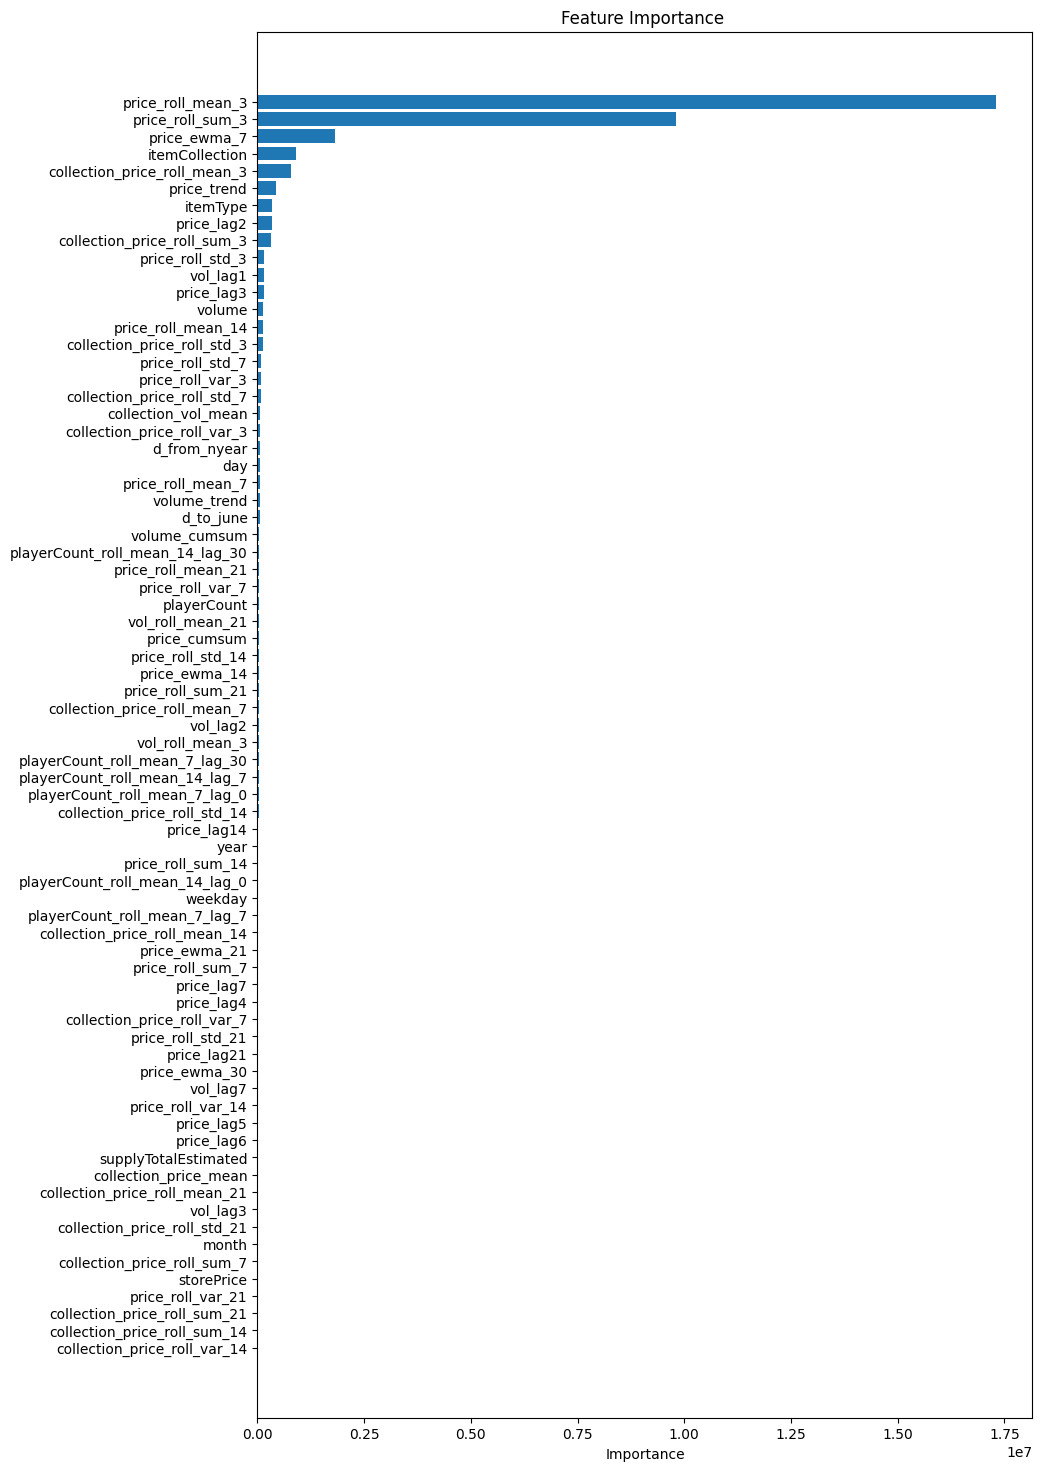

In [ ]:
trim=0
print_importances(model,trim,False,figsize=(10, 18))

In [ ]:
for i in range(len(models)):
  print_importances(models[f"model_horizon_{i+1}"],0,False,name=f" N={i+1}'",figsize=(7, 2),end=10)


In [ ]:
from google.colab import runtime
runtime.unassign()